# Żabka — Invoice/Basket Analysis (Notebook)

**Files expected:**
- Raw receipts: `PANPARAGON-1065-04092025.xlsx`
- Product mapping (optional but recommended): `product_mapping_auto.xlsx`



In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, os
from pathlib import Path
import pandas as pd, re, unicodedata
from difflib import SequenceMatcher
from textwrap import shorten


In [14]:
# local file paths
DATA_PATH = Path("data/PANPARAGON-1065-04092025.xlsx")
MAPPING_PATH = Path("data/product_mapping_auto.xlsx")
MENU_PATH = "data/zabka_food_corner_menu_canonical.csv"


In [4]:
# helper functions
def fix_polish_mojibake(s):
    if not isinstance(s, str): 
        return s
    if any(ch in s for ch in ["Ã","Å","Â","Ê","Œ","œ"]):
        try:
            return s.encode("latin-1","ignore").decode("utf-8","ignore")
        except Exception:
            return s
    return s

def norm_str(s):
    if not isinstance(s, str): 
        return s
    s = fix_polish_mojibake(s)
    return re.sub(r"\s+", " ", s).strip().lower()

def clean_ean_series(x):
    return (pd.Series(x, dtype="object")
              .astype(str)
              .str.replace(r"\.0$", "", regex=True)
              .str.replace(r"\s+", "", regex=True)
              .str.strip())

def slot_label(h):
    if 6 <= h < 9:
        return "06:00–09:00 going to work"
    elif 9 <= h < 12:
        return "09:00–12:00 morning groceries"
    elif 12 <= h < 17:
        return "12:00–17:00 lunch time"
    elif 17 <= h < 23:
        return "17:00–23:00 after work"
    elif 23 <= h or h < 6:
        return "23:00–06:00 late night / early morning"


In [5]:
# load and preprocess data
raw = pd.read_excel(DATA_PATH, header=2)
df = raw.rename(columns={
    "ID Paragonu": "receipt_id",
    "Numer paragonu": "receipt_number",
    "Data zakupu": "date",
    "Godzina zakupu": "time",
    "EAN": "ean",
    "Nazwa produktu": "product",
    "Ilość": "qty",
    "Cena jednostkowa brutto": "unit_price_gross",
    "Cena jednostkowa netto (po uwzględnieniu ewentualnych rabatów)": "unit_price_net",
    "Rabat": "discount",
    "Kasjer": "cashier",
    "Metoda płatności": "payment_method"
})
df = df.dropna(subset=["receipt_id","date","time","product"]).copy()

# Keys + numerics
df["product"] = df["product"].apply(fix_polish_mojibake)
df["product_norm"] = df["product"].apply(norm_str)
df["ean_key"] = clean_ean_series(df["ean"])
df["ts"] = pd.to_datetime(pd.to_datetime(df["date"]).dt.date.astype(str) + " " + df["time"].astype(str), errors="coerce")
df["hour"] = df["ts"].dt.hour

for c in ["qty","unit_price_gross","unit_price_net","discount"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

if df.get("unit_price_gross") is not None and df["unit_price_gross"].notna().any():
    df["line_total_gross"] = df["qty"] * df["unit_price_gross"]
elif "unit_price_net" in df.columns:
    df["line_total_gross"] = df["qty"] * df["unit_price_net"]
else:
    df["line_total_gross"] = np.nan

df["slot"] = df["hour"].apply(slot_label)

# ---------- Load mapping ----------
xls = pd.ExcelFile(MAPPING_PATH)
sheet = "auto_mapping" if "auto_mapping" in xls.sheet_names else xls.sheet_names[0]
mapping = pd.read_excel(MAPPING_PATH, sheet_name=sheet, dtype={"ean": object}).copy()
mapping.columns = [c.strip().lower() for c in mapping.columns]

req = {"ean","product","is_food_corner","type_food_or_bev_or_other"}
missing = req - set(mapping.columns)
if missing:
    raise ValueError(f"Mapping missing columns: {missing}")

mapping["ean_key"] = clean_ean_series(mapping["ean"])
mapping["product"] = mapping["product"].astype(str).map(fix_polish_mojibake)
mapping["product_norm"] = mapping["product"].map(norm_str)
mapping["is_food_corner"] = (
    mapping["is_food_corner"].astype(str).str.strip().str.lower()
    .replace({"tak":"yes","nie":"no","true":"yes","false":"no","y":"yes","n":"no","1":"yes","0":"no"})
)

# ---------- Merge on (EAN + product_norm), then EAN-only fallback ----------
merged = df.merge(
    mapping[["ean_key","product_norm","is_food_corner","type_food_or_bev_or_other"]]
            .drop_duplicates(["ean_key","product_norm"]),
    how="left",
    on=["ean_key","product_norm"]
)
hit_both = merged["is_food_corner"].notna().mean()

fallback = (mapping[["ean_key","is_food_corner","type_food_or_bev_or_other"]]
            .drop_duplicates("ean_key"))
merged_ean = df.merge(fallback, how="left", on="ean_key", suffixes=("","_ean"))
hit_ean = merged_ean["is_food_corner"].notna().mean()

if hit_ean > hit_both:
    merged = merged_ean
else:
    merged = merged.merge(fallback, how="left", on="ean_key", suffixes=("","_ean"))
    merged["is_food_corner"] = merged["is_food_corner"].fillna(merged["is_food_corner_ean"])
    merged["type_food_or_bev_or_other"] = merged["type_food_or_bev_or_other"].fillna(
        merged["type_food_or_bev_or_other_ean"]
    )
    merged.drop(columns=[c for c in merged.columns if c.endswith("_ean")], inplace=True)

merged["is_food_corner_flag"] = merged["is_food_corner"].astype(str).str.strip().str.lower().eq("yes")
merged["fc_type"] = merged["type_food_or_bev_or_other"].astype(str).str.strip().str.lower()


## Metrics

In [6]:
# ---------- Diagnostics ----------
print({
    "mapping_rows": len(mapping),
    "mapping_yes": int((mapping["is_food_corner"].str.lower()=="yes").sum()),
    "match_rate_any_label": float(merged["is_food_corner"].notna().mean()),
    "fc_lines": int(merged["is_food_corner_flag"].sum()),
    "fc_unique_products": int(merged.loc[merged["is_food_corner_flag"], "product"].nunique()),
    "date_range": (str(merged["ts"].min()), str(merged["ts"].max())),
    "receipts_total": int(merged["receipt_id"].nunique())
})

{'mapping_rows': 935, 'mapping_yes': 108, 'match_rate_any_label': 1.0, 'fc_lines': 229, 'fc_unique_products': 108, 'date_range': ('2025-07-16 05:52:00', '2025-07-16 23:00:00'), 'receipts_total': 1018}


In [7]:
# ---------- Basic basket metrics ----------
basket = df.groupby(["receipt_id","slot"], as_index=False).agg(
    basket_value=("line_total_gross","sum"),
    items=("qty","sum")
)
basic_overall = (basket.groupby("slot", as_index=False)
                 .agg(avg_basket_value=("basket_value","mean"),
                      avg_items_per_receipt=("items","mean"),
                      receipts=("receipt_id","nunique"))
                 .sort_values("slot"))
print("\nBasic basket metrics — overall:")
basic_overall.round(2)



Basic basket metrics — overall:


,slot,avg_basket_value,avg_items_per_receipt,receipts
0,06:00–09:00 going to work,22.15,2.56,127
1,09:00–12:00 morning groceries,20.24,2.63,145
2,12:00–17:00 lunch time,23.39,2.79,339
3,17:00–23:00 after work,24.65,2.74,399
4,23:00–06:00 late night / early morning,31.64,2.00,2


In [8]:

fc = merged[merged["is_food_corner_flag"]].copy()
basket_fc = fc.groupby(["receipt_id","slot"], as_index=False).agg(
    basket_value=("line_total_gross","sum"),
    items=("qty","sum")
)
basic_fc = (basket_fc.groupby("slot", as_index=False)
            .agg(avg_basket_value=("basket_value","mean"),
                 avg_items_per_receipt=("items","mean"),
                 receipts=("receipt_id","nunique"))
            .sort_values("slot"))
print("\nBasic basket metrics — FC only:")
basic_fc.round(2)



Basic basket metrics — FC only:


,slot,avg_basket_value,avg_items_per_receipt,receipts
0,06:00–09:00 going to work,8.41,1.24,23
1,09:00–12:00 morning groceries,9.36,1.27,27
2,12:00–17:00 lunch time,9.29,1.31,70
3,17:00–23:00 after work,8.59,1.40,78


In [9]:
# ---------- FC mix ----------
fc_receipt_ids = fc["receipt_id"].unique()
in_fc_receipts = merged[merged["receipt_id"].isin(fc_receipt_ids)].copy()
mix = (in_fc_receipts.groupby("fc_type", as_index=False)["line_total_gross"].sum()
       .rename(columns={"line_total_gross":"value"})
       .sort_values("value", ascending=False))
mix["value_share"] = mix["value"] / mix["value"].sum() if mix["value"].sum() else 0.0
print("\nFC mix (value & share) within FC receipts:")
print(mix.round(3))



FC mix (value & share) within FC receipts:
    fc_type     value  value_share
2     other  2514.646        0.478
1      food  1670.751        0.317
0  beverage  1079.710        0.205


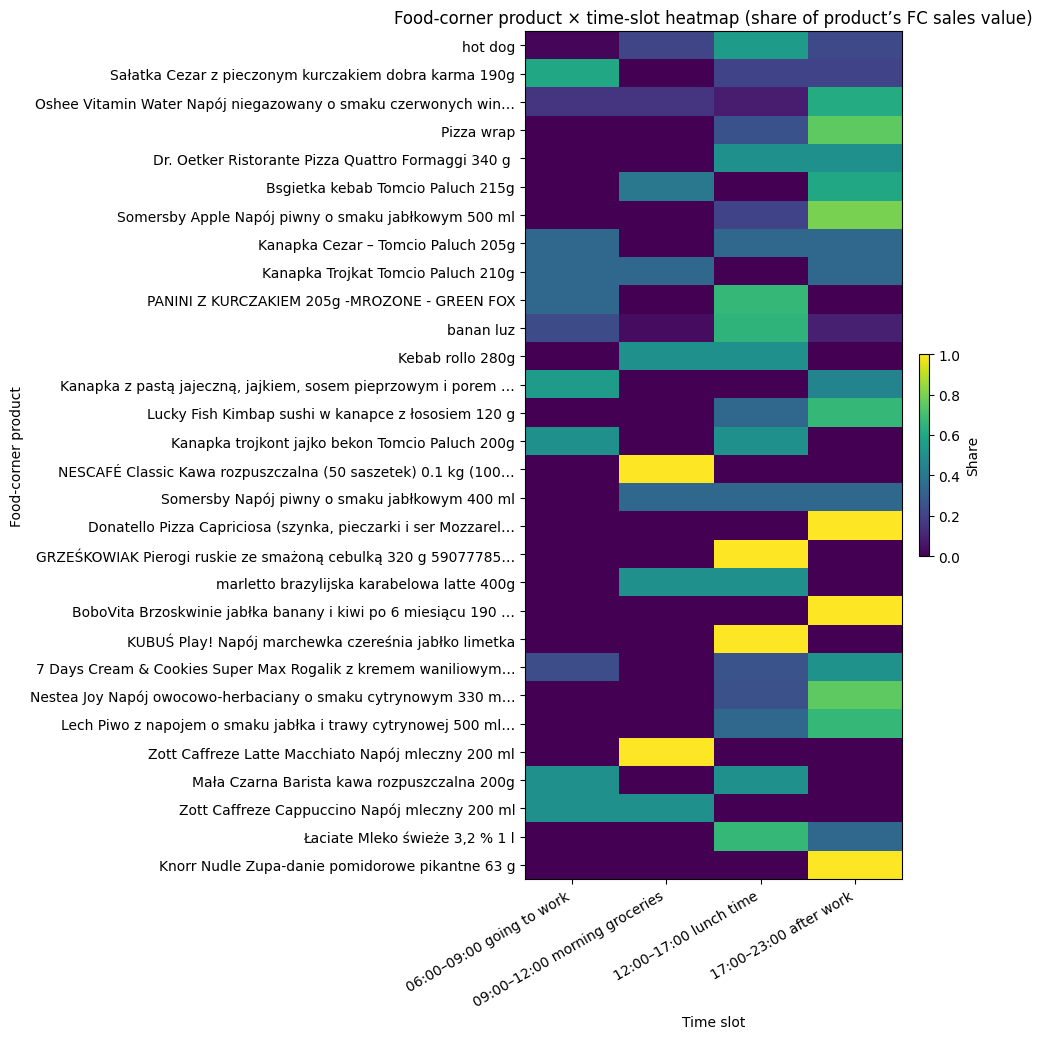

In [10]:
# ---------- Heatmap: FC products × time slot ----------
if fc.empty:
    raise ValueError("No FC lines after merge — cannot plot heatmap.")
by_ps = (fc.groupby(["product","slot"], as_index=False)["line_total_gross"]
           .sum().rename(columns={"line_total_gross":"sales_value"}))
mat = by_ps.pivot(index="product", columns="slot", values="sales_value").fillna(0.0)
slot_order = [s for s in [
    "06:00–09:00 going to work",
    "09:00–12:00 morning groceries",
    "12:00–17:00 lunch time",
    "17:00–23:00 after work",
    "23:00–06:00 late night / early morning",
] if s in mat.columns]
mat = mat.reindex(columns=[s for s in slot_order if s in mat.columns], fill_value=0.0)
TOP_N = 30
top = mat.loc[mat.sum(axis=1).sort_values(ascending=False).head(TOP_N).index]
row_sums = top.sum(axis=1).replace(0, np.nan)
top_share = top.div(row_sums, axis=0).fillna(0.0)

plt.figure(figsize=(10, max(6, top_share.shape[0] * 0.35)))
im = plt.imshow(top_share.values, aspect="auto")  
plt.xticks(
    range(top_share.shape[1]),
    list(top_share.columns),
    rotation=30,
    ha="right"
)
plt.yticks(range(top_share.shape[0]), [p[:60] + ("…" if len(p) > 60 else "") for p in top_share.index])
plt.xlabel("Time slot")
plt.ylabel("Food-corner product")
plt.title("Food-corner product × time-slot heatmap (share of product’s FC sales value)")
cbar = plt.colorbar(im, fraction=0.025, pad=0.04); cbar.set_label("Share")
plt.tight_layout(); plt.show()

## Basic analysis

In [11]:
# ==== REPORT 1 & 2: per-slot KPIs ====
# basket per receipt & slot
basket = (df.groupby(["receipt_id","slot"], as_index=False)
            .agg(basket_value=("line_total_gross","sum"),
                 items=("qty","sum")))

# KPIs per slot
kpis = (basket.groupby("slot", as_index=False)
              .agg(avg_basket_value=("basket_value","mean"),
                   avg_items_per_receipt=("items","mean"),
                   receipts=("receipt_id","nunique"))
              .sort_values("slot"))
print("Per-slot KPIs (avg value, avg items, receipt count):")
display(kpis.round(2))

Per-slot KPIs (avg value, avg items, receipt count):


,slot,avg_basket_value,avg_items_per_receipt,receipts
0,06:00–09:00 going to work,22.15,2.56,127
1,09:00–12:00 morning groceries,20.24,2.63,145
2,12:00–17:00 lunch time,23.39,2.79,339
3,17:00–23:00 after work,24.65,2.74,399
4,23:00–06:00 late night / early morning,31.64,2.00,2



Sample of rankings:


,slot,product,sales_value,units,rank_by_value,rank_by_units
86,06:00–09:00 going to work,Papierosy Davidoff EVOLVED BLUE,179.91,9.0,1.0,3.0
85,06:00–09:00 going to work,Papierosy CHESTERFIELD BLUE,102.50,5.0,2.0,5.0
90,06:00–09:00 going to work,Papierosy L&M FIRST CUT,97.50,5.0,3.0,5.0
87,06:00–09:00 going to work,Papierosy KENT BLUE 100's,78.00,4.0,4.0,6.0
68,06:00–09:00 going to work,Monster Energy Gazowany napój energetyczny 500 ml,69.90,10.0,5.0,2.0
298,09:00–12:00 morning groceries,Papierosy RGD BLUE superslim,199.90,10.0,1.0,2.0
370,09:00–12:00 morning groceries,Żubr Piwo jasne 500 ml,99.78,22.0,2.0,1.0
289,09:00–12:00 morning groceries,Papierosy L&M FIRST CUT BRIGHT,97.50,5.0,3.0,6.0
363,09:00–12:00 morning groceries,hot dog,81.90,10.0,4.0,2.0
249,09:00–12:00 morning groceries,Monster Energy Gazowany napój energetyczny 500 ml,62.91,9.0,5.0,3.0


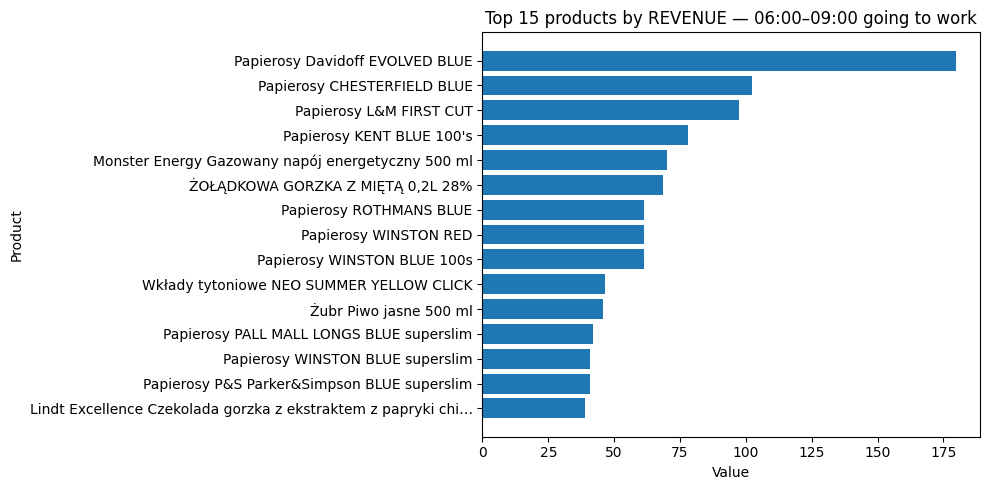

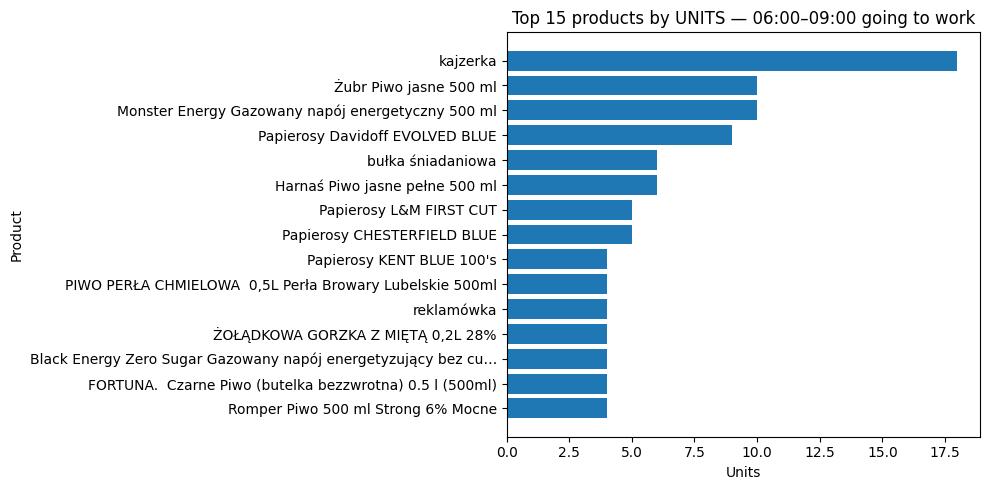

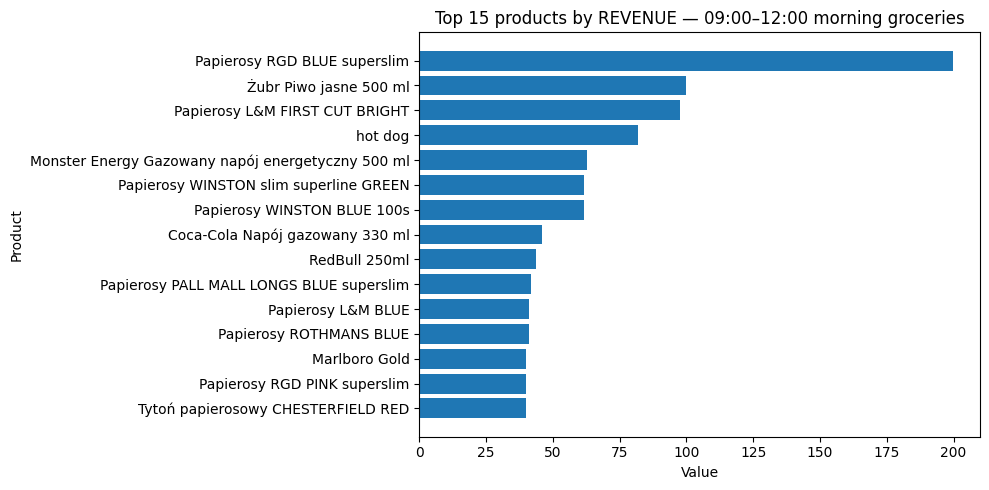

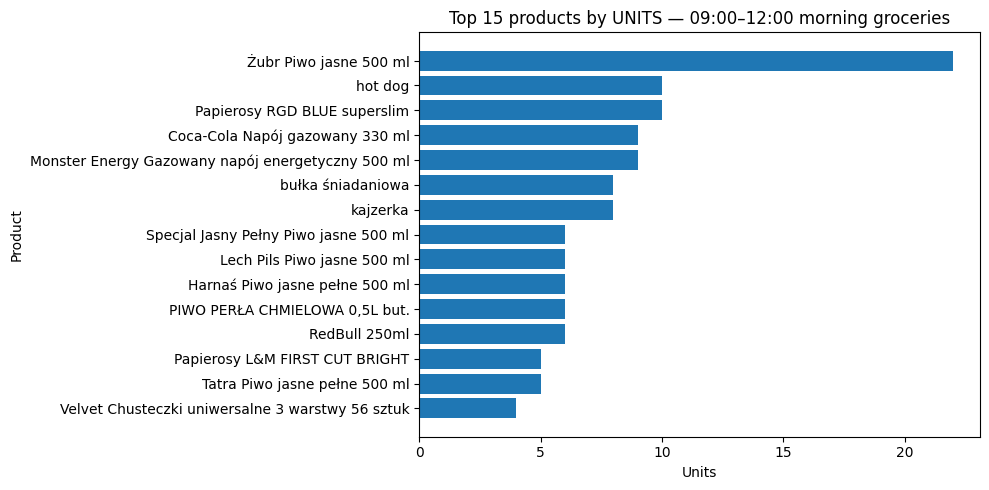

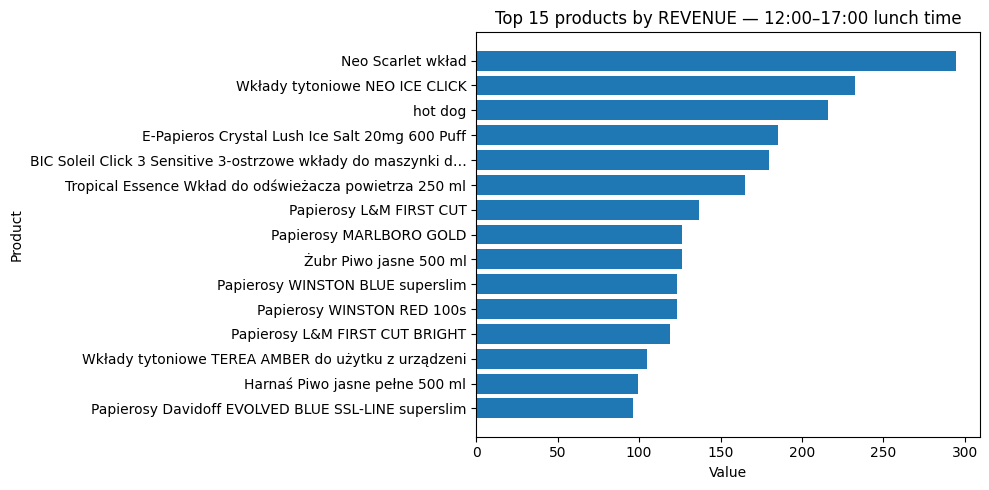

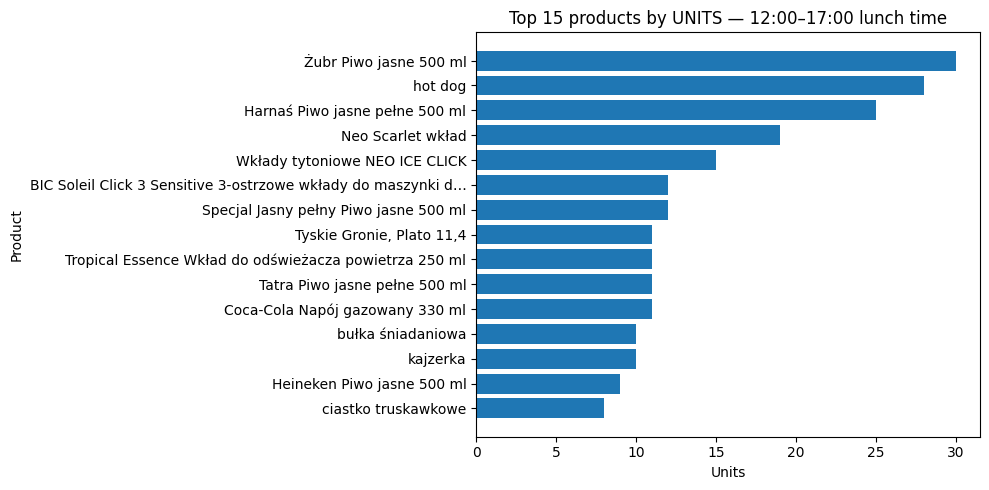

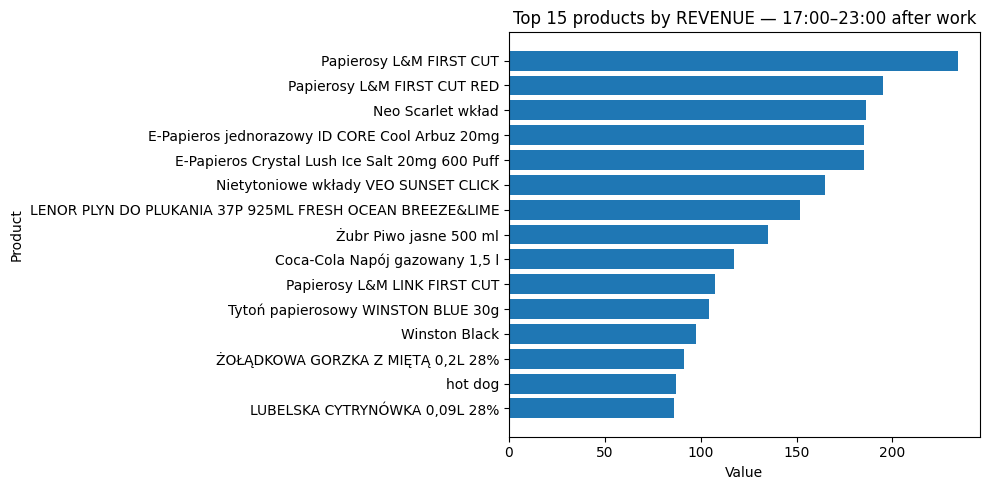

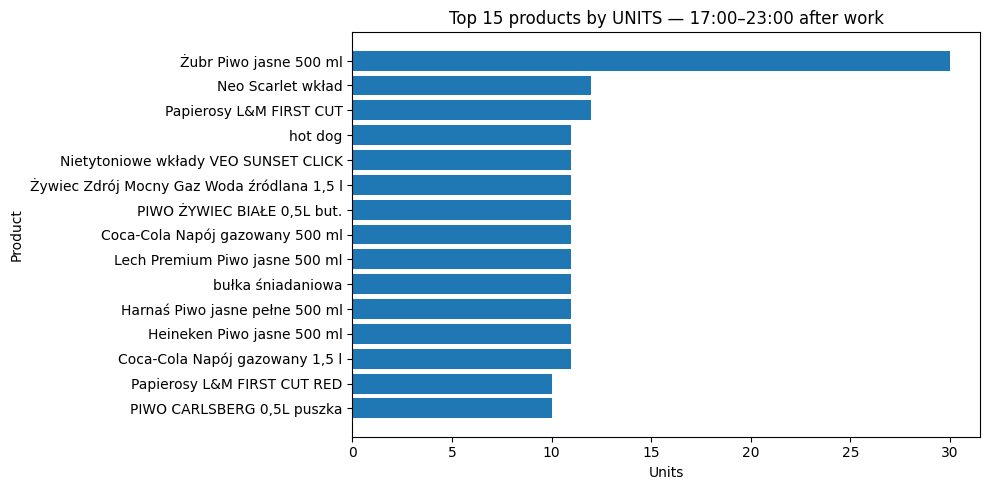

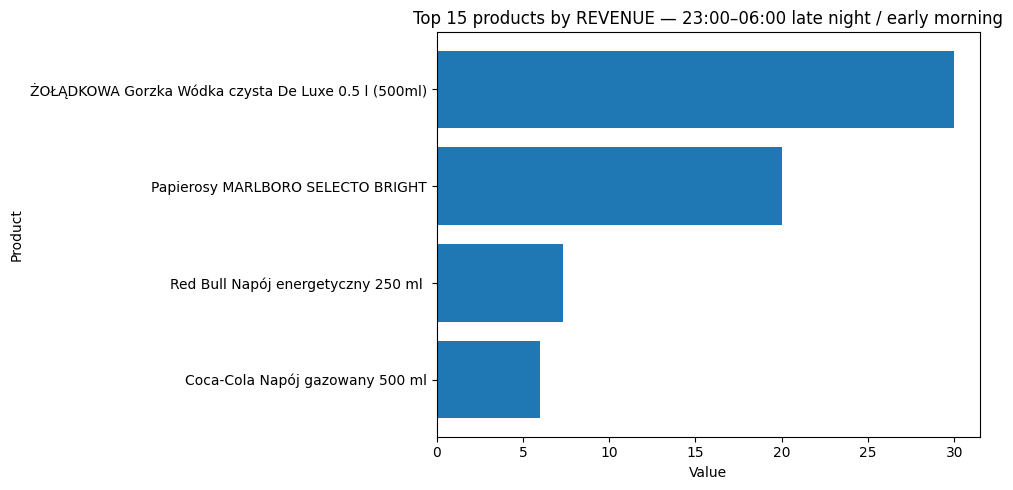

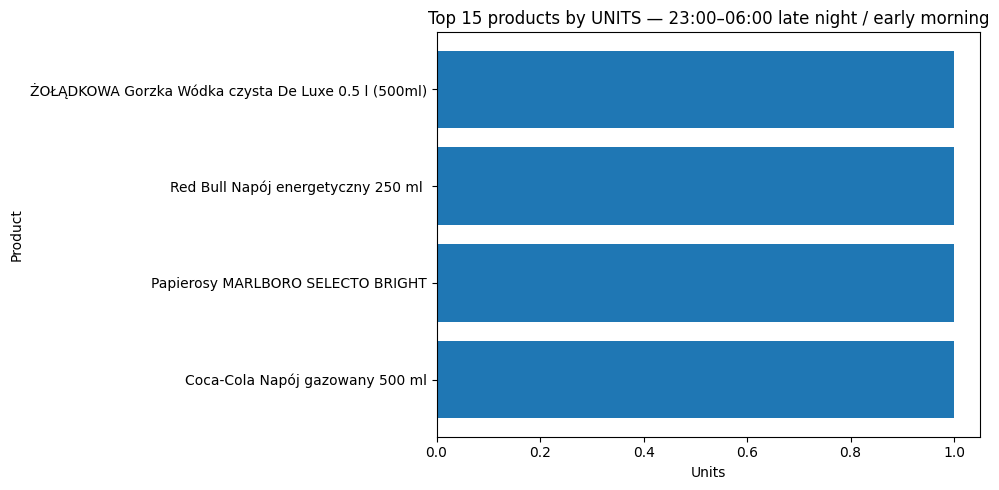

In [12]:
# ==== REPORT 3: rankings by value & by units (per slot) ====
rank = (df.groupby(["slot","product"], as_index=False)
          .agg(sales_value=("line_total_gross","sum"),
               units=("qty","sum")))

# Ranks inside each slot
rank["rank_by_value"] = rank.groupby("slot")["sales_value"].rank(ascending=False, method="dense")
rank["rank_by_units"] = rank.groupby("slot")["units"].rank(ascending=False, method="dense")

# optional: export for sharing
rank.sort_values(["slot","rank_by_value","rank_by_units"]).to_csv("sales_ranking_by_slot.csv", index=False)

print("\nSample of rankings:")
display(rank.sort_values(["slot","rank_by_value"]).groupby("slot").head(5).round(2))


# ==== VISUALIZATION: ranked histograms per slot ====
import matplotlib.pyplot as plt

TOP_N = 15  # adjust if you want more labels visible

def plot_ranked_bars(df_rank_slot, value_col, title_prefix):
    # keep top N by the chosen value column
    top = df_rank_slot.sort_values(value_col, ascending=False).head(TOP_N)
    # order left->right by rank
    top = top.sort_values(value_col, ascending=True)

    plt.figure(figsize=(10, 5))
    plt.barh(top["product"], top[value_col])  # default matplotlib colors
    plt.title(f"{title_prefix}")
    plt.xlabel("Value" if value_col == "sales_value" else "Units")
    plt.ylabel("Product")

    # tidy y labels (they're product names)
    plt.yticks(range(len(top["product"])), [p[:60] + ("…" if len(p) > 60 else "") for p in top["product"]])

    plt.tight_layout()
    plt.show()


# loop slots and plot both rankings
slot_list = list(rank["slot"].dropna().unique())
for s in slot_list:
    rslot = rank[rank["slot"] == s]

    # Plot by sales value
    plot_ranked_bars(rslot, "sales_value", f"Top {TOP_N} products by REVENUE — {s}")

    # Plot by units
    plot_ranked_bars(rslot, "units", f"Top {TOP_N} products by UNITS — {s}")

In [15]:
def strip_diacritics(s: str) -> str:
    return "".join(ch for ch in unicodedata.normalize("NFKD", s) if not unicodedata.combining(ch))

def normalize_text(s: str) -> str:
    if not isinstance(s, str): return ""
    s = fix_polish_mojibake(s).lower()
    s = strip_diacritics(s)
    s = re.sub(r"[^a-z0-9\s/+-]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

STOPWORDS = set("""z ze za na w i oraz s a do zupa sos klasyczny klasyczne drob
promo gratis szt sztuk sztuka sztuki opak opakowanie puszka butelka duzy mala medium
xl xxl mini mix pack zestaw kg g ml l xb""".split())

def tokens(s: str):
    return [t for t in normalize_text(s).split() if t not in STOPWORDS]

def token_set_score(a: str, b: str) -> float:
    ta, tb = set(tokens(a)), set(tokens(b))
    if not ta or not tb: return 0.0
    return len(ta & tb) / len(ta | tb)

def seq_ratio(a: str, b: str) -> float:
    return SequenceMatcher(None, normalize_text(a), normalize_text(b)).ratio()

def hybrid_score(a: str, b: str) -> float:
    return 0.6 * token_set_score(a, b) + 0.4 * seq_ratio(a, b)

# Load data
raw = pd.read_excel(DATA_PATH, header=2)
df = raw.rename(columns={
    "ID Paragonu": "receipt_id",
    "Numer paragonu": "receipt_number",
    "Data zakupu": "date",
    "Godzina zakupu": "time",
    "EAN": "ean",
    "Nazwa produktu": "product",
    "Ilość": "qty",
    "Cena jednostkowa brutto": "unit_price_gross",
    "Cena jednostkowa netto (po uwzględnieniu ewentualnych rabatów)": "unit_price_net",
    "Rabat": "discount",
    "Kasjer": "cashier",
    "Metoda płatności": "payment_method"
}).dropna(subset=["receipt_id","date","time","product"]).copy()
df["product"] = df["product"].apply(fix_polish_mojibake)

menu = pd.read_csv(MENU_PATH)
menu["menu_item_norm"] = menu["menu_item"].apply(normalize_text)
menu["menu_tokens"] = menu["menu_item"].apply(tokens)

catalog = (df.groupby(["ean","product"], as_index=False)
             .size()
             .rename(columns={"size":"lines_count"})
             .sort_values("lines_count", ascending=False))
catalog["product_norm"] = catalog["product"].apply(normalize_text)
catalog["prod_tokens"] = catalog["product"].apply(tokens)

def best_match_for_row(row, threshold=0.55):
    ptoks = set(row["prod_tokens"])
    if not ptoks:
        return pd.Series({"match_item":"", "match_category":"", "score":0.0})
    # Candidate pruning by shared tokens
    cand_idx = [i for i, toks in enumerate(menu["menu_tokens"]) if ptoks & set(toks)]
    if not cand_idx:
        cand_idx = list(range(len(menu)))
    best_score, best_i = -1.0, None
    for i in cand_idx:
        sc = hybrid_score(row["product"], menu.loc[i, "menu_item"])
        if sc > best_score:
            best_score, best_i = sc, i
    if best_i is None or best_score < threshold:
        return pd.Series({"match_item":"", "match_category":"", "score":float(best_score if best_i is not None else 0.0)})
    return pd.Series({"match_item": menu.loc[best_i, "menu_item"],
                      "match_category": menu.loc[best_i, "menu_category"],
                      "score": float(best_score)})

matches = catalog.apply(best_match_for_row, axis=1)
catalog_matched = pd.concat([catalog, matches], axis=1)
catalog_matched["is_food_corner_auto"] = catalog_matched["match_item"].ne("")
catalog_matched = catalog_matched.sort_values(["is_food_corner_auto","score","lines_count"], ascending=[False, False, False])

# Save mapping
catalog_matched.to_csv("auto_fc_mapping_from_menu.csv", index=False)
print("Saved auto FC mapping to auto_fc_mapping_from_menu.csv")

# Optional: quick counts
print(catalog_matched["is_food_corner_auto"].value_counts())
print(catalog_matched.query("is_food_corner_auto and score>=0.7")[["product","match_item","score"]].head(10))

Saved auto FC mapping to auto_fc_mapping_from_menu.csv
is_food_corner_auto
False    926
True       9
Name: count, dtype: int64
                 product                  match_item     score
890  Bagietka katalonska         Bagietka Katalońska  1.000000
30    kotlet de volaille  Kotlet de volaille z purée  0.777273


## Perfect Analysis

In [24]:
# ---------------------------
# Paths
# ---------------------------
DATA_PATH = Path("data/PANPARAGON-1065-04092025.xlsx")
AUTO_MAP = Path("auto_fc_mapping_from_menu.csv")
OUT_DIR = Path("outputs")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# ---------------------------
# Helpers
# ---------------------------
def fix_polish_mojibake(s):
    if not isinstance(s, str): return s
    if any(ch in s for ch in ["Ã","Å","Â","Ê","Œ","œ"]):
        try: return s.encode("latin-1","ignore").decode("utf-8","ignore")
        except Exception: return s
    return s

def slot_label(h):
    if 6 <= h < 9:   return "06:00–09:00 going to work"
    if 9 <= h < 12:  return "09:00–12:00 morning groceries"
    if 12 <= h < 17: return "12:00–17:00 lunch time"
    if 17 <= h < 23: return "17:00–23:00 after work"
    return "23:00–06:00 late night / early morning"

def save_table_png(df: pd.DataFrame, path: Path, title: str = "", max_rows: int = 30, col_width=200):
    """
    Render a dataframe as a PNG image using matplotlib.
    - Truncates to max_rows to keep image readable
    - Auto-wraps/truncates long strings
    """
    d = df.copy()
    if len(d) > max_rows:
        d = d.head(max_rows)

    # shorten long text cells for readability
    for c in d.columns:
        if d[c].dtype == object:
            d[c] = d[c].astype(str).apply(lambda x: shorten(x, width=70, placeholder="…"))

    nrows, ncols = d.shape
    fig_h = max(2.0, 0.35 * (nrows + 1))
    fig_w = max(6.0, min(16.0, 0.08 * col_width * ncols / 96.0))  # heuristic for width

    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    ax.axis("off")
    if title:
        ax.set_title(title, pad=12)
    tbl = ax.table(cellText=d.values, colLabels=d.columns, loc="center", cellLoc="left")
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(8)
    tbl.scale(1, 1.2)
    fig.tight_layout()
    fig.savefig(path, dpi=200, bbox_inches="tight")
    plt.close(fig)

def save_bar_png(x, y, title, ylabel, path, rotation=30):
    plt.figure(figsize=(8, 4.5))
    plt.bar(x, y)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotation, ha="right")
    plt.tight_layout()
    plt.savefig(path, dpi=200)
    plt.close()

def save_barh_png(labels, values, title, xlabel, path):
    plt.figure(figsize=(10, max(5, 0.4 * len(labels))))
    plt.barh(labels, values)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.tight_layout()
    plt.savefig(path, dpi=200)
    plt.close()

def safe_name(s: str) -> str:
    return re.sub(r"[^a-zA-Z0-9._-]+", "_", s)[:80]

# ---------------------------
# Load receipts
# ---------------------------
raw = pd.read_excel(DATA_PATH, header=2)
df = (raw.rename(columns={
        "ID Paragonu": "receipt_id",
        "Numer paragonu": "receipt_number",
        "Data zakupu": "date",
        "Godzina zakupu": "time",
        "EAN": "ean",
        "Nazwa produktu": "product",
        "Ilość": "qty",
        "Cena jednostkowa brutto": "unit_price_gross",
        "Cena jednostkowa netto (po uwzględnieniu ewentualnych rabatów)": "unit_price_net",
        "Rabat": "discount",
        "Kasjer": "cashier",
        "Metoda płatności": "payment_method"
    })
    .dropna(subset=["receipt_id","date","time","product"])
    .copy()
)
df["product"] = df["product"].apply(fix_polish_mojibake)

# numerics & totals
for c in ["qty","unit_price_gross","unit_price_net","discount"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

if "unit_price_gross" in df.columns and df["unit_price_gross"].notna().any():
    df["line_total_gross"] = df["qty"] * df["unit_price_gross"]
elif "unit_price_net" in df.columns:
    df["line_total_gross"] = df["qty"] * df["unit_price_net"]
else:
    df["line_total_gross"] = np.nan

df["ts"] = pd.to_datetime(pd.to_datetime(df["date"]).dt.date.astype(str) + " " + df["time"].astype(str), errors="coerce")
df["hour"] = df["ts"].dt.hour
df["slot"] = df["hour"].apply(slot_label)

# ---------------------------
# Load auto FC mapping & merge
# ---------------------------
auto_map = pd.read_csv(AUTO_MAP)
df = df.merge(
    auto_map[["ean","product","match_item","match_category","score","is_food_corner_auto"]],
    how="left", on=["ean","product"]
)
df["is_fc"] = df["is_food_corner_auto"].fillna(False).astype(bool)

# ---------------------------
# 1) Per-slot KPIs (overall)
# ---------------------------
basket = (df.groupby(["receipt_id","slot"], as_index=False)
            .agg(basket_value=("line_total_gross","sum"),
                 items=("qty","sum")))
kpis_overall = (basket.groupby("slot", as_index=False)
                .agg(avg_basket_value=("basket_value","mean"),
                     avg_items_per_receipt=("items","mean"),
                     receipts=("receipt_id","nunique"))
                .sort_values("slot"))
kpis_overall_csv = OUT_DIR/"kpis_overall_by_slot.csv"
kpis_overall.to_csv(kpis_overall_csv, index=False)
save_table_png(kpis_overall.round(2), OUT_DIR/"kpis_overall_by_slot.png",
               title="Per-slot KPIs — overall (avg basket value | avg items | receipts)")

save_bar_png(kpis_overall["slot"], kpis_overall["avg_basket_value"],
             "Avg basket value by slot — overall",
             "Average basket value (gross)",
             OUT_DIR/"plot_avg_basket_value_overall_by_slot.png")
save_bar_png(kpis_overall["slot"], kpis_overall["receipts"],
             "Receipts count by slot — overall",
             "Unique receipts",
             OUT_DIR/"plot_receipts_overall_by_slot.png")

# ---------------------------
# 2) FC-only per-slot KPIs
# ---------------------------
fc = df[df["is_fc"]].copy()
basket_fc_lines = (fc.groupby(["receipt_id","slot"], as_index=False)
                     .agg(basket_value=("line_total_gross","sum"),
                          items=("qty","sum")))
kpis_fc = (basket_fc_lines.groupby("slot", as_index=False)
            .agg(avg_basket_value=("basket_value","mean"),
                 avg_items_per_receipt=("items","mean"),
                 receipts=("receipt_id","nunique"))
            .sort_values("slot"))
kpis_fc_csv = OUT_DIR/"kpis_fc_only_by_slot.csv"
kpis_fc.to_csv(kpis_fc_csv, index=False)
save_table_png(kpis_fc.round(2), OUT_DIR/"kpis_fc_only_by_slot.png",
               title="Per-slot KPIs — FC-only lines")

fc_by_slot = (fc.groupby("slot", as_index=False)
                .agg(sales_value=("line_total_gross","sum"),
                     units=("qty","sum"),
                     receipts=("receipt_id","nunique"))
                .sort_values("slot"))
fc_by_slot_csv = OUT_DIR/"fc_by_slot_value_units_receipts.csv"
fc_by_slot.to_csv(fc_by_slot_csv, index=False)
save_table_png(fc_by_slot.round(2), OUT_DIR/"fc_by_slot_value_units_receipts.png",
               title="FC by slot — value | units | receipts")

save_bar_png(fc_by_slot["slot"], fc_by_slot["sales_value"],
             "FC sales value by slot", "Sales value (gross)",
             OUT_DIR/"plot_fc_sales_value_by_slot.png")

# ---------------------------
# 3) Mix within FC receipts (FC vs Non-FC)
# ---------------------------
fc_receipt_ids = set(df.loc[df["is_fc"], "receipt_id"].unique())
in_fc_receipts = df[df["receipt_id"].isin(fc_receipt_ids)].copy()
mix_in_fc = (in_fc_receipts.assign(fc_label=np.where(in_fc_receipts["is_fc"], "FC items","Non-FC items"))
             .groupby("fc_label", as_index=False)
             .agg(value=("line_total_gross","sum"),
                  units=("qty","sum")))
mix_in_fc["value_share"] = mix_in_fc["value"]/mix_in_fc["value"].sum() if mix_in_fc["value"].sum() else 0.0
mix_in_fc["units_share"] = mix_in_fc["units"]/mix_in_fc["units"].sum() if mix_in_fc["units"].sum() else 0.0
mix_in_fc_csv = OUT_DIR/"mix_within_fc_receipts.csv"
mix_in_fc.to_csv(mix_in_fc_csv, index=False)
save_table_png(mix_in_fc.round(3), OUT_DIR/"mix_within_fc_receipts.png",
               title="Sales mix within FC receipts — FC vs Non-FC")

# simple bar (value)
save_bar_png(mix_in_fc["fc_label"], mix_in_fc["value"],
             "Sales value in FC receipts — FC vs Non-FC",
             "Value (gross)",
             OUT_DIR/"plot_mix_value_fc_vs_nonfc.png", rotation=0)

# ---------------------------
# 4) Rankings within FC (fast & slow movers)
# ---------------------------
rank_fc = (df.loc[df["is_fc"]]
             .groupby("product", as_index=False)
             .agg(sales_value=("line_total_gross","sum"),
                  units=("qty","sum"))
             .sort_values(["sales_value","units"], ascending=False))
rank_fc_csv = OUT_DIR/"rank_fc_all_products.csv"
rank_fc.to_csv(rank_fc_csv, index=False)
save_table_png(rank_fc.head(30).round(2), OUT_DIR/"rank_fc_all_products_TOP30.png",
               title="FC ranking (value & units) — TOP 30")

TOP_N = 20
fast_movers = rank_fc.head(TOP_N)
slow_movers = rank_fc[rank_fc["sales_value"]>0].tail(TOP_N)
fast_movers.to_csv(OUT_DIR/"fast_movers_top20_value.csv", index=False)
slow_movers.to_csv(OUT_DIR/"slow_movers_bottom20_value_gt0.csv", index=False)
save_table_png(fast_movers.round(2), OUT_DIR/"fast_movers_top20_value.png",
               title="Fast movers — top 20 (by value)")
save_table_png(slow_movers.round(2), OUT_DIR/"slow_movers_bottom20_value_gt0.png",
               title="Slow movers — bottom 20>0 (by value)")

# plots for fast movers (horizontal bars)
tmp = fast_movers.sort_values("sales_value", ascending=True)
labels = [shorten(x, width=60, placeholder="…") for x in tmp["product"].astype(str)]
save_barh_png(labels, tmp["sales_value"],
              f"Fast movers — top {TOP_N} by value",
              "Sales value (gross)",
              OUT_DIR/"plot_fast_movers_top20_value.png")

# ---------------------------
# 5) Rankings per slot (value & units)
# ---------------------------
rank_slot = (df.groupby(["slot","product"], as_index=False)
               .agg(sales_value=("line_total_gross","sum"),
                    units=("qty","sum")))
rank_slot["rank_by_value"] = rank_slot.groupby("slot")["sales_value"].rank(ascending=False, method="dense")
rank_slot["rank_by_units"] = rank_slot.groupby("slot")["units"].rank(ascending=False, method="dense")

top_by_val = (rank_slot.sort_values(["slot","rank_by_value"])
                       .groupby("slot").head(30))
top_by_units = (rank_slot.sort_values(["slot","rank_by_units"])
                         .groupby("slot").head(30))
top_by_val_csv = OUT_DIR/"top_products_by_value_per_slot.csv"
top_by_units_csv = OUT_DIR/"top_products_by_units_per_slot.csv"
top_by_val.to_csv(top_by_val_csv, index=False)
top_by_units.to_csv(top_by_units_csv, index=False)
save_table_png(top_by_val.round(2), OUT_DIR/"top_products_by_value_per_slot.png",
               title="Top products by VALUE per slot (TOP 30 each)")
save_table_png(top_by_units.round(2), OUT_DIR/"top_products_by_units_per_slot.png",
               title="Top products by UNITS per slot (TOP 30 each)")

# per-slot plots
for s in rank_slot["slot"].dropna().unique():
    r = rank_slot[rank_slot["slot"] == s]
    d_val = r.sort_values("sales_value", ascending=False).head(15).sort_values("sales_value")
    d_units = r.sort_values("units", ascending=False).head(15).sort_values("units")
    lbl_val = [shorten(x, width=60, placeholder="…") for x in d_val["product"].astype(str)]
    lbl_units = [shorten(x, width=60, placeholder="…") for x in d_units["product"].astype(str)]
    save_barh_png(lbl_val, d_val["sales_value"],
                  f"Top 15 by VALUE — {s}",
                  "Sales value (gross)",
                  OUT_DIR/f"plot_top15_value_{safe_name(s)}.png")
    save_barh_png(lbl_units, d_units["units"],
                  f"Top 15 by UNITS — {s}",
                  "Units",
                  OUT_DIR/f"plot_top15_units_{safe_name(s)}.png")

# ---------------------------
# 6) FC heatmap (share by slot) — RED/BLUE
# ---------------------------
if not fc.empty:
    by_ps = (fc.groupby(["product","slot"], as_index=False)["line_total_gross"]
               .sum().rename(columns={"line_total_gross":"sales_value"}))
    mat = by_ps.pivot(index="product", columns="slot", values="sales_value").fillna(0.0)
    slot_order = [
        "06:00–09:00 going to work",
        "09:00–12:00 morning groceries",
        "12:00–17:00 lunch time",
        "17:00–23:00 after work",
        "23:00–06:00 late night / early morning",
    ]
    mat = mat.reindex(columns=[s for s in slot_order if s in mat.columns], fill_value=0.0)
    TOP_N_HM = 30
    top = mat.loc[mat.sum(axis=1).sort_values(ascending=False).head(TOP_N_HM).index]
    row_sums = top.sum(axis=1).replace(0, np.nan)
    top_share = top.div(row_sums, axis=0).fillna(0.0)

    plt.figure(figsize=(10, max(6, 0.35 * len(top_share))))
    im = plt.imshow(top_share.values, aspect="auto", cmap="bwr")  # red/blue colormap
    plt.xticks(range(top_share.shape[1]), list(top_share.columns), rotation=30, ha="right")
    ylabels = [shorten(x, width=60, placeholder="…") for x in top_share.index]
    plt.yticks(range(top_share.shape[0]), ylabels)
    plt.xlabel("Time slot"); plt.ylabel("Food-corner product")
    plt.title("FC products × time slot — share of product’s FC sales value")
    cbar = plt.colorbar(im, fraction=0.025, pad=0.04); cbar.set_label("Share")
    plt.tight_layout()
    plt.savefig(OUT_DIR/"plot_fc_heatmap_share_bwr.png", dpi=200)
    plt.close()
else:
    print("No FC lines found — heatmap skipped.")

# ---------------------------
# 7) FC share per receipt (diagnostic)
# ---------------------------
fc_value_by_receipt = (df[df["is_fc"]].groupby("receipt_id", as_index=False)["line_total_gross"].sum()
                       .rename(columns={"line_total_gross":"fc_value"}))
basket_value_by_receipt = (df.groupby("receipt_id", as_index=False)["line_total_gross"].sum()
                           .rename(columns={"line_total_gross":"basket_value"}))
share = basket_value_by_receipt.merge(fc_value_by_receipt, how="left", on="receipt_id").fillna({"fc_value":0})
share["fc_share"] = np.where(share["basket_value"]>0, share["fc_value"]/share["basket_value"], 0.0)
share_fc_only = share[share["fc_value"]>0].copy()

share.to_csv(OUT_DIR/"fc_share_per_receipt_all.csv", index=False)
share_fc_only.to_csv(OUT_DIR/"fc_share_per_receipt_only_fc_receipts.csv", index=False)
save_table_png(share_fc_only.round(3).head(50), OUT_DIR/"fc_share_per_receipt_only_fc_receipts.png",
               title="FC share per receipt — sample (receipts with any FC)")

plt.figure(figsize=(8, 4.5))
plt.hist(share_fc_only["fc_share"], bins=20)
plt.title("Distribution: FC share of basket (receipts with any FC)")
plt.xlabel("FC share of basket value"); plt.ylabel("Receipts")
plt.tight_layout()
plt.savefig(OUT_DIR/"plot_fc_share_hist.png", dpi=200)
plt.close()

print("\nCSV and PNG exports written to:", OUT_DIR.resolve())


CSV and PNG exports written to: /home/alonbenach/project/invoice-analysis/outputs


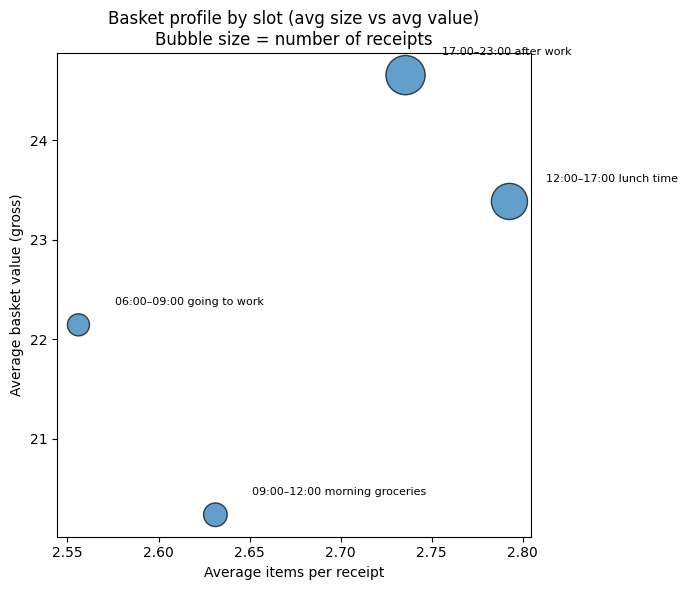

In [25]:
# === Refined scatter for Points 1 & 2 ===

# Drop outlier slot "23:00–06:00 late night / early morning"
basket_no_outlier = basket[basket["slot"] != "23:00–06:00 late night / early morning"]

kpis_overall_no_outlier = (basket_no_outlier.groupby("slot", as_index=False)
    .agg(avg_basket_value=("basket_value","mean"),
         avg_items_per_receipt=("items","mean"),
         receipts=("receipt_id","nunique"))
    .sort_values("slot"))

# Scatter plot: avg items vs avg basket value
plt.figure(figsize=(7,6))
plt.scatter(kpis_overall_no_outlier["avg_items_per_receipt"],
            kpis_overall_no_outlier["avg_basket_value"],
            s=kpis_overall_no_outlier["receipts"]*2,  # bubble size = # receipts
            c="tab:blue", alpha=0.7, edgecolors="black")

for i,row in kpis_overall_no_outlier.iterrows():
    plt.text(row["avg_items_per_receipt"]+0.02,
             row["avg_basket_value"]+0.2,
             row["slot"], fontsize=8)

plt.xlabel("Average items per receipt")
plt.ylabel("Average basket value (gross)")
plt.title("Basket profile by slot (avg size vs avg value)\nBubble size = number of receipts")
plt.tight_layout()
plt.savefig(OUT_DIR/"plot_scatter_items_vs_value_by_slot.png", dpi=200)
plt.show()


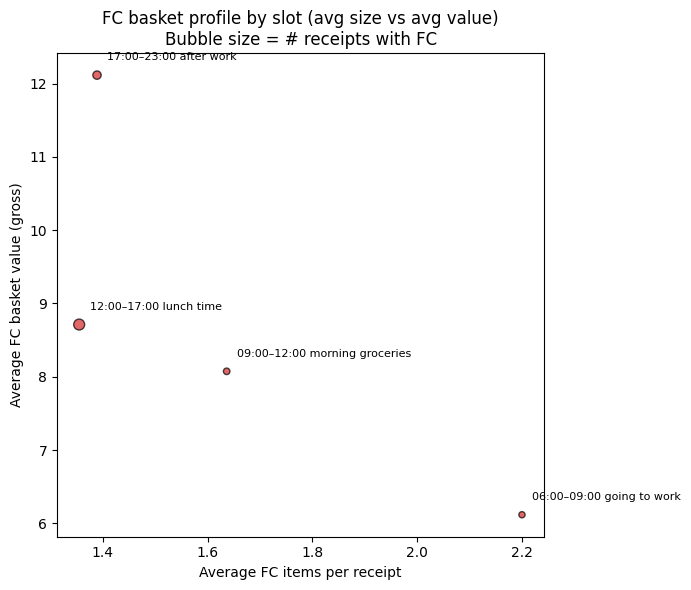

In [26]:
# === Refined scatter for Point b (Perfect check — FC receipts) ===

basket_fc_lines_no_outlier = basket_fc_lines[basket_fc_lines["slot"] != "23:00–06:00 late night / early morning"]

kpis_fc_no_outlier = (basket_fc_lines_no_outlier.groupby("slot", as_index=False)
    .agg(avg_basket_value=("basket_value","mean"),
         avg_items_per_receipt=("items","mean"),
         receipts=("receipt_id","nunique"))
    .sort_values("slot"))

plt.figure(figsize=(7,6))
plt.scatter(kpis_fc_no_outlier["avg_items_per_receipt"],
            kpis_fc_no_outlier["avg_basket_value"],
            s=kpis_fc_no_outlier["receipts"]*2,
            c="tab:red", alpha=0.7, edgecolors="black")

for i,row in kpis_fc_no_outlier.iterrows():
    plt.text(row["avg_items_per_receipt"]+0.02,
             row["avg_basket_value"]+0.2,
             row["slot"], fontsize=8)

plt.xlabel("Average FC items per receipt")
plt.ylabel("Average FC basket value (gross)")
plt.title("FC basket profile by slot (avg size vs avg value)\nBubble size = # receipts with FC")
plt.tight_layout()
plt.savefig(OUT_DIR/"plot_scatter_items_vs_value_by_slot_FC.png", dpi=200)
plt.show()


In [29]:
# === ONE-PAGER: Top-5 FC co-purchases as a single, pretty image ===
# Prereqs: you already ran the main pipeline; `df` contains: receipt_id, product, is_fc, line_total_gross
# Also assumes OUT_DIR = Path("outputs") exists (from earlier cell)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from textwrap import shorten
from PIL import Image, ImageDraw, ImageFont

OUT_DIR = Path("outputs")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# 1) Top-5 FC items by sales value
top5_fc = (df[df["is_fc"]]
             .groupby("product", as_index=False)["line_total_gross"].sum()
             .sort_values("line_total_gross", ascending=False)
             .head(5)["product"].tolist())

# 2) Receipt -> set of products
receipt_products = df.groupby("receipt_id")["product"].apply(set)

# 3) Co-purchases: for each top FC item, find top-K other items by receipt co-occurrence
TOP_K = 8
copurchase_dict = {}
agg_rows = []

for item in top5_fc:
    receipts_with_item = receipt_products[receipt_products.apply(lambda prods: item in prods)]
    co_counts = {}
    for prods in receipts_with_item:
        for other in prods:
            if other != item:
                co_counts[other] = co_counts.get(other, 0) + 1
    co_df = (pd.DataFrame(list(co_counts.items()), columns=["co_item","co_count"])
             .sort_values("co_count", ascending=False)
             .head(TOP_K))
    copurchase_dict[item] = co_df
    for _, r in co_df.iterrows():
        agg_rows.append({"fc_item": item, "co_item": r["co_item"], "co_count": int(r["co_count"])})

copurchase_all = pd.DataFrame(agg_rows)
copurchase_all.to_csv(OUT_DIR/"copurchases_top5_fc_all.csv", index=False)

# 4) Make one chart per FC item (horizontal bars, annotated), save to temp PNGs
def plot_copurchase_chart(item: str, co_df: pd.DataFrame, path: Path):
    sub = co_df.sort_values("co_count", ascending=True)  # smallest at bottom, bars grow to the right
    labels = [shorten(str(x), width=60, placeholder="…") for x in sub["co_item"]]
    values = sub["co_count"].values

    plt.figure(figsize=(10, max(3.5, 0.5*len(labels))))
    bars = plt.barh(labels, values)  # default matplotlib colors
    # annotate counts at bar ends
    for b, v in zip(bars, values):
        plt.text(b.get_width() + max(values)*0.01, b.get_y() + b.get_height()/2, str(int(v)),
                 va="center", fontsize=9)
    plt.title(f"Top co-purchases with: {item}", pad=8)
    plt.xlabel("Receipts (co-occurrence count)")
    plt.tight_layout()
    plt.savefig(path, dpi=200)
    plt.close()

temp_paths = []
for item, co_df in copurchase_dict.items():
    p = OUT_DIR / f"_tmp_cop_{abs(hash(item))}.png"
    plot_copurchase_chart(item, co_df, p)
    temp_paths.append(p)

# 5) Compose into a single tall image (stacked charts with a header)
def compose_vertical(images, header_text, out_path: Path, padding=20, bg=(255,255,255)):
    # Load images
    ims = [Image.open(p).convert("RGB") for p in images]
    widths = [im.width for im in ims]
    max_w = max(widths)
    total_h = sum(im.height for im in ims) + padding*(len(ims)+1) + 80  # + header

    canvas = Image.new("RGB", (max_w + 2*padding, total_h), bg)
    draw = ImageDraw.Draw(canvas)

    # Header
    title = header_text
    # Use default PIL font (portable). If you want a bigger font and have ttf, you can load it via ImageFont.truetype(...)
    draw.text((padding, padding), title, fill=(0,0,0))
    y = padding + 60

    # Paste charts
    for im in ims:
        x = padding + (max_w - im.width)//2
        canvas.paste(im, (x, y))
        y += im.height + padding

    canvas.save(out_path, dpi=(200,200))

final_img = OUT_DIR / "onepager_copurchases_top5_fc.png"
compose_vertical(
    temp_paths,
    header_text="Top co-purchases for the Top-5 Food Corner items (receipt-level co-occurrence)",
    out_path=final_img
)

# Optional: clean temp files
for p in temp_paths:
    try:
        p.unlink()
    except Exception:
        pass

print("Saved:", final_img)


Saved: outputs/onepager_copurchases_top5_fc.png


In [30]:
# === AGGREGATED CO-PURCHASES: Top-5 FC items vs all other products ===

TOP_K_AGG = 15  # top N co-purchases to show

# 1) Top-5 FC items (already computed)
top5_fc = (df[df["is_fc"]]
             .groupby("product", as_index=False)["line_total_gross"].sum()
             .sort_values("line_total_gross", ascending=False)
             .head(5)["product"].tolist())

# 2) Get all receipts containing ANY of the top-5 FC items
receipt_products = df.groupby("receipt_id")["product"].apply(set)
receipts_with_top5 = receipt_products[receipt_products.apply(lambda prods: len(prods & set(top5_fc)) > 0)]

# 3) Count co-occurring products (excluding the top-5 themselves)
co_counts = {}
for prods in receipts_with_top5:
    for other in prods:
        if other not in top5_fc:
            co_counts[other] = co_counts.get(other, 0) + 1

agg_df = (pd.DataFrame(list(co_counts.items()), columns=["co_item","co_count"])
            .sort_values("co_count", ascending=False)
            .head(TOP_K_AGG))

agg_df.to_csv(OUT_DIR/"copurchases_top5_fc_aggregated.csv", index=False)
save_table_png(agg_df, OUT_DIR/"copurchases_top5_fc_aggregated.png",
               title="Top co-purchases with ANY of the Top-5 FC items")

# 4) Plot a nice horizontal bar chart
sub = agg_df.sort_values("co_count", ascending=True)
labels = [shorten(str(x), width=60, placeholder="…") for x in sub["co_item"]]
values = sub["co_count"].values

plt.figure(figsize=(10, max(4, 0.5*len(labels))))
bars = plt.barh(labels, values, color="steelblue")
for b, v in zip(bars, values):
    plt.text(b.get_width() + max(values)*0.01, b.get_y() + b.get_height()/2, str(int(v)),
             va="center", fontsize=9)
plt.title("Top co-purchases with ANY Top-5 FC items", pad=8)
plt.xlabel("Receipts count (co-occurrence)")
plt.tight_layout()
plt.savefig(OUT_DIR/"plot_copurchases_top5_fc_aggregated.png", dpi=200)
plt.close()

print("Saved aggregated co-purchase table & plot in:", OUT_DIR.resolve())


Saved aggregated co-purchase table & plot in: /home/alonbenach/project/invoice-analysis/outputs
